# Summary
learn a reduced model for when you apply the POD seperately. 


# To do
* fix $\xi=10$, run the ML model. See performance. Then devise a way to get rid of divergence. See how is the performance and then if required play with $\xi$. I think if the performance in the test set is good then the chaotic attractor is probably good too.
* Generated data to impose dissipation for this .


# Load Data

In [3]:
import numpy as np
import sys
sys.path.append('./../')
import torch
import torch.nn as nn
import torch.optim as optim
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from ProcessFunctions import find_Aisv2,Find_a_i,find_Aisv2_onlyv
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.nn.functional as F
from scipy.interpolate import interp1d
import seaborn as sns 
import cte_eq

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [5]:
T_final=10500
Ntout=cte_eq.Ntout
Nxout=cte_eq.Nxout
drs=0.012
data_dir='/central/groups/astuart/hkaveh/Data/LearnROM/transfer/MainSimulation2D_Tf'+str(T_final)+"Nt="+str(Ntout)+"Nx="+str(Nxout)+'PODonlyonV'+'drs'+str(drs)+".npz"
PODmodes=np.load(data_dir)
U_v=PODmodes['U']
S_v=PODmodes['S']
# VT_v=PODmodes['VT']
q_bar_v=PODmodes['q_bar']

In [6]:
# Loading POD modes


data_dir='/central/groups/astuart/hkaveh/Data/LearnROM/transfer/MainSimulation2D_Tf'+str(T_final)+"Nt="+str(Ntout)+"Nx="+str(Nxout)+'PODonlyontheta'+'drs'+str(drs)+".npz"

PODmodes=np.load(data_dir)
U_theta=PODmodes['U']
S_theta=PODmodes['S']
# VT_theta=PODmodes['VT']
q_bar_theta=PODmodes['q_bar']

In [7]:
# radi_outer=25
# radi_inner=24


In [37]:
# Loading data from "/central/groups/astuart/hkaveh/Data/LearnROM/transfer/SampleSimulation_Tf_2D'+str(T_final_run)+"Nt="+str(cte_eq.Ntout)+"N_m"+str(N_m)+"coeff"+str(coeff)+"number"+str(index)"
T_final_run = 350 # each initial condition is simulated for 250 years
Nt=5     # it is recorded every Nt time stes
N_m_v=20 # number of modes that they have considered
N_m_theta=20 # number of modes that they have considered
coeff=1 # How the inital conditions are from the chaotic attractor
number=10 # Which one do you want to load
N_cut=2000
# loading time series:
N_m_load=30

X_full=np.empty((1,N_m_load*2))
Y_full=np.empty((1,N_m_load*2))


for number in range(1,100):
    data_dir='/central/groups/astuart/hkaveh/Data/LearnROM/transfer/SampleSimulation_Tf_2D'+str(T_final_run)+"Nt="+str(cte_eq.Ntout)+"N_m"+str(N_m_load)+"coeff"+str(coeff)+"number"+str(number)+".npz"
    data_smaple=np.load(data_dir)

    V_ox=data_smaple['array1']
    theta_ox=data_smaple['array2']
    t_ox=data_smaple['array3']
    # removing data with probability p
    xi=100
    p_remove=np.tanh(xi*np.max(V_ox,axis=1))
    Nt_sample=p_remove.shape[0]
    print( "number of points in this member is:", Nt_sample)
    keep_mask_sample=np.random.rand(Nt_sample) > p_remove
    # We work with log10 of V_ox and theta_ox:
    V_ox=np.log10(V_ox)
    theta_ox=np.log10(theta_ox)
    A_v,P_v=find_Aisv2_onlyv(U_v,V_ox,q_bar_v,N_m_load) # you dont need P in general, but I need it to check if I do everything correctly
    A_theta,P_theta=find_Aisv2_onlyv(U_theta,theta_ox,q_bar_theta,N_m_load)
    # concatenating the two arrays
    A=np.concatenate((A_v,A_theta),axis=1)
    X_onesimulation=A[:-1,:]         # current step
    Y_onesimulation=A[1:,:]-A[:-1,:] # next step minus the current step
    print("shape of X_onesimulation before is",X_onesimulation.shape)
    X_onesimulation=X_onesimulation[keep_mask_sample[:-1]]
    Y_onesimulation=Y_onesimulation[keep_mask_sample[:-1]]
    print("shape of X_onesimulation after is",X_onesimulation.shape)

    X_full=np.append(X_full,X_onesimulation,axis=0)
    Y_full=np.append(Y_full,Y_onesimulation,axis=0)
    print("number is " +str(number)+ " size of data in this simulation is " +str(X_onesimulation.shape[0])+" total size is " + str(X_full.shape[0]))

# removing the first row which is empty
X_full=X_full[1:,:]
Y_full=Y_full[1:,:]

# print(np.max(X_full))
print(np.max(Y_full))
# Loading the the numpy arrays Input and Output which are generated for imposing dissipiation far away from the attractor
# # commenting here:
# data_dir="/central/groups/astuart/hkaveh/Data/LearnROM/EllipticShell_radi_outer"+str(radi_outer)+"radi_inner"+str(radi_inner)+"PODappliedseperately.npz"

# data_smaple=np.load(data_dir)
# Input_X=data_smaple['Input']
# Output_Y=data_smaple['Output']
# # appending the Input_X to the X_full and Output_Y to the Y_full
# # appending the Input_X to the X_full and Output_Y to the Y_full, but append from the begining of the array
# print(np.max(Output_Y))
# X_full=np.append(Input_X,X_full,axis=0)
# Y_full=np.append(Output_Y,Y_full,axis=0)
# # untill here

# deleting some colomns from X_full and Y_full that are should not be included based on N_m_v and N_m_theta
# index of the columns that should be deleted
index_delete=np.array([])
if N_m_v<N_m_load:
    index_delete=np.append(index_delete,np.arange(N_m_v,N_m_load))
if N_m_theta<N_m_load:
    index_delete=np.append(index_delete,np.arange(N_m_load+N_m_theta,2*N_m_load))


# Convert the array elements to integers
index_delete = index_delete.astype(int)

X_full=np.delete(X_full,index_delete,axis=1)
Y_full=np.delete(Y_full,index_delete,axis=1)
print("index of the columns that are deleted are:")
print(index_delete)

print(X_full.shape)
print("size of the data is " +str(X_full.shape[0]))
# 50, 55, 59, 63, 72, 73,79,81

number of points in this member is: 7014
shape of X_onesimulation before is (7013, 60)
shape of X_onesimulation after is (533, 60)
number is 1 size of data in this simulation is 533 total size is 534
number of points in this member is: 8407
shape of X_onesimulation before is (8406, 60)
shape of X_onesimulation after is (639, 60)
number is 2 size of data in this simulation is 639 total size is 1173
number of points in this member is: 7618
shape of X_onesimulation before is (7617, 60)
shape of X_onesimulation after is (534, 60)
number is 3 size of data in this simulation is 534 total size is 1707
number of points in this member is: 9083
shape of X_onesimulation before is (9082, 60)
shape of X_onesimulation after is (592, 60)
number is 4 size of data in this simulation is 592 total size is 2299
number of points in this member is: 9928
shape of X_onesimulation before is (9927, 60)
shape of X_onesimulation after is (710, 60)
number is 5 size of data in this simulation is 710 total size is 3

In [38]:
from scipy.stats import shapiro

for i in range(10):
    stat, p = shapiro(X_onesimulation[:, i])
    print(f"PC {i+1}: Shapiro p-value = {p}")

PC 1: Shapiro p-value = 4.83684085949716e-26
PC 2: Shapiro p-value = 2.443578383445962e-19
PC 3: Shapiro p-value = 6.951544700798038e-19
PC 4: Shapiro p-value = 1.1147314182835544e-09
PC 5: Shapiro p-value = 0.0014661687891930342
PC 6: Shapiro p-value = 8.904881726681693e-16
PC 7: Shapiro p-value = 1.336738608258975e-14
PC 8: Shapiro p-value = 0.00010807815124280751
PC 9: Shapiro p-value = 1.9043787814060353e-12
PC 10: Shapiro p-value = 5.70859026716164e-10


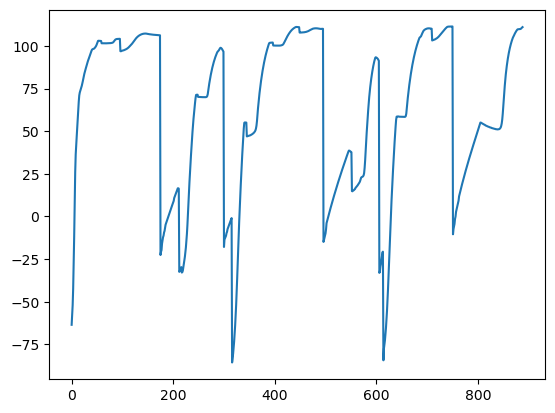

In [39]:
plt.plot(X_onesimulation[:, 0])

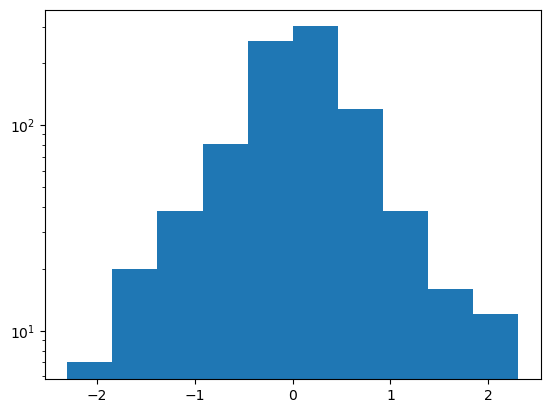

In [40]:
plt.hist(Y_onesimulation[:,3])
plt.yscale("log")

In [41]:
U_v.shape

(1024, 1024)

In [42]:
X_onesimulation.shape

(889, 60)

In [43]:
(U_v[:,:30]@X_onesimulation[i,:30]).shape

(1024,)

In [44]:
q_bar_v.shape

(1024, 1)

In [45]:
log10_v=(U_v[:,:30]@X_onesimulation[i,:30])+q_bar_v.reshape(1024,)

In [46]:
X_onesimulation.shape

(889, 60)

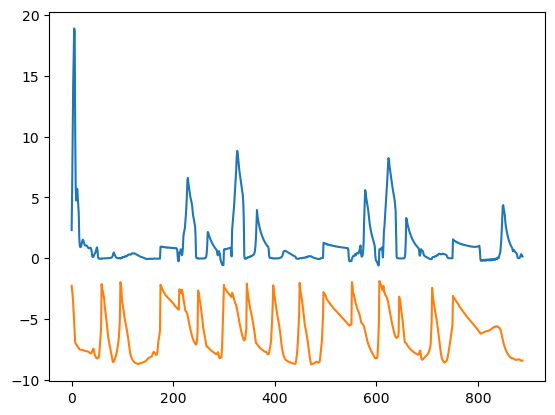

In [47]:
plt.plot(Y_onesimulation[:,0])
# find v from alpha
log_v=np.zeros((X_onesimulation.shape[0],1024))
for i in range(X_onesimulation.shape[0]):
    log_v[i,:]=U_v[:,:30]@X_onesimulation[i,:30]+q_bar_v.reshape(1024,)
max_log_v=np.max(log_v,axis=1)
plt.plot(max_log_v)

In [48]:
log_v.shape

(889, 1024)

In [49]:
log_v.shape

(889, 1024)

Text(0.5, 1.0, 'Histogram of the norm of X_full along each row')

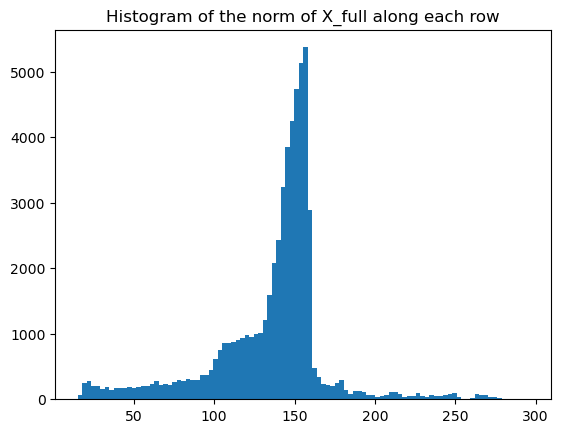

In [50]:
# Plot the histogram of the  norm of X_full along each row
norm_X_full=np.linalg.norm(X_full,axis=1)
plt.hist(norm_X_full,bins=100)
plt.title("Histogram of the norm of X_full along each row")

In [51]:
# # Plot the histogram of the  norm of X_full along each row
# norm_X_full=np.linalg.norm(Input_X,axis=1)
# plt.hist(norm_X_full,bins=100)
# plt.title("Histogram of the norm of X_full along each row")

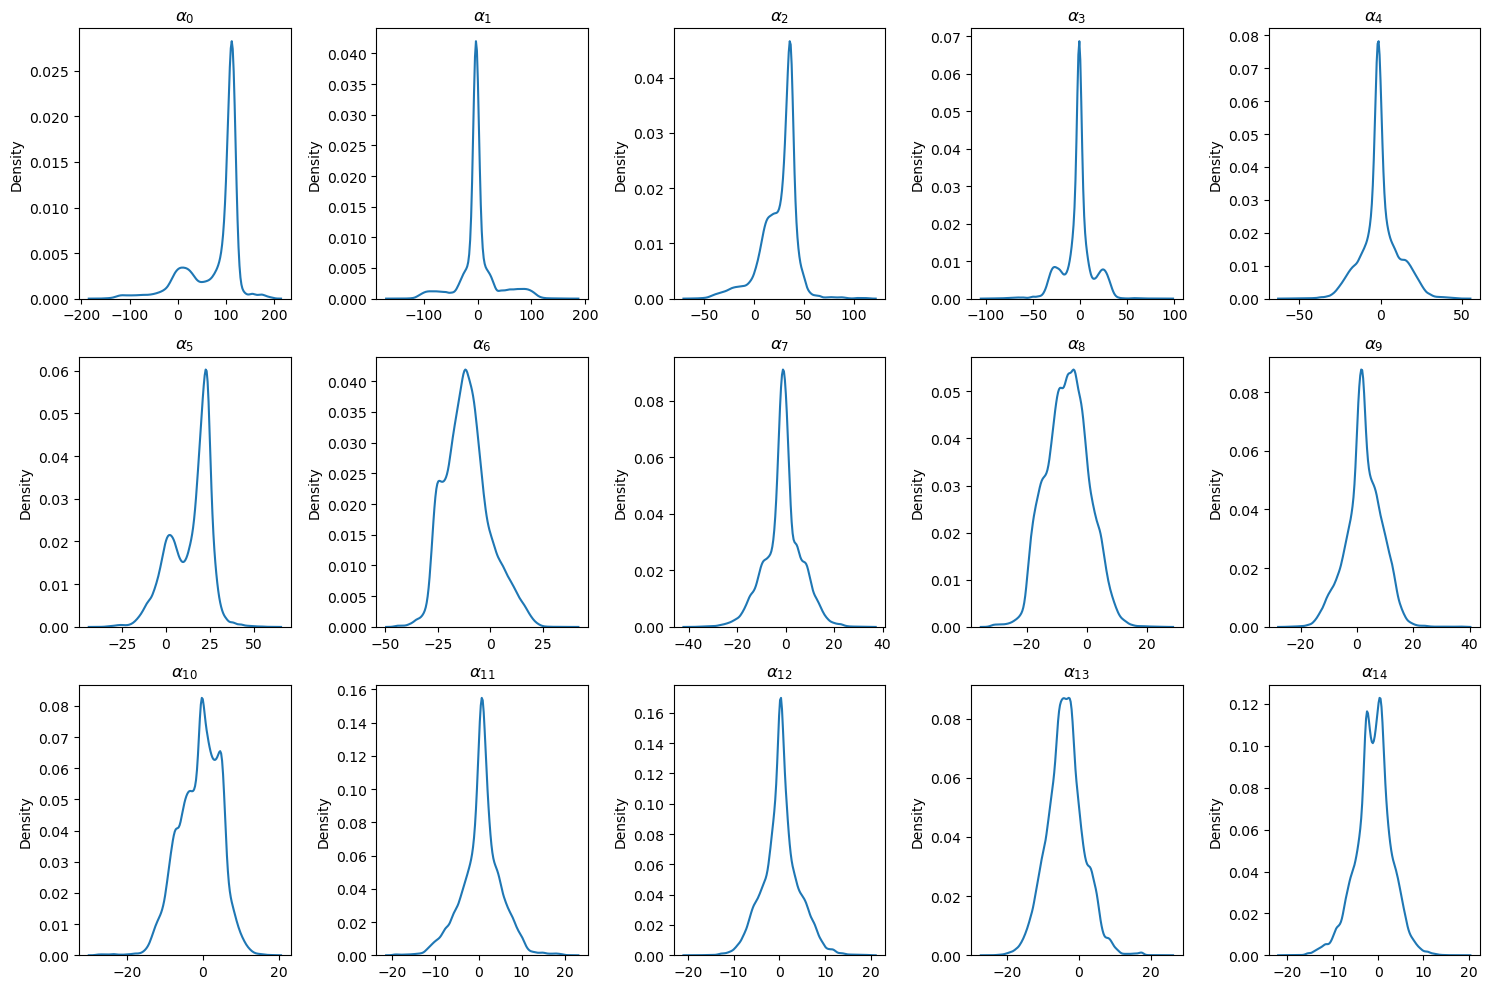

In [52]:
# Create a figure and axis objects
fig, axs = plt.subplots(3, 5, figsize=(15, 10))

# Flatten the axs array so that we can iterate over it easily
axs = axs.flatten()

# Plot the KDE plot for each column of X_full
for i in range(15):
    sns.kdeplot(X_full[:, i], ax=axs[i])
    axs[i].set_title(r'$\alpha_{{{}}}$'.format(i))

# Adjust layout and show plot
plt.tight_layout()
plt.show()



# Preprocessing Data

In [53]:
X_cut=X_full[-N_cut:,:]
Y_cut=Y_full[-N_cut:,:]
X=X_full[1:-N_cut,:] # Also, removing the first element
Y=Y_full[1:-N_cut,:] 
# rescale
# # comment from here:
# max_X=np.max(X)
# max_y=np.max(Y)

# X=X/max_X
# Y=Y/max_y
# X_cut=X_cut/max_X
# Y_cut=Y_cut/max_y
# # untill here




In [54]:
# print(max_X)
# print(max_y)

In [55]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)
# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [56]:
print("Target Y range:")
print("  Min:", Y_train_tensor.min().item())
print("  Max:", Y_train_tensor.max().item())
print("  Std:", Y_train_tensor.std().item())

Target Y range:
  Min: -10.558049201965332
  Max: 16.89401626586914
  Std: 0.7196794748306274


Target Y range:
  Min: -118.23153686523438
  Max: 430.5366516113281
  Std: 11.744479179382324

In [57]:
11.7/2.8

4.178571428571429

In [58]:
11.7/(430+118)

0.02135036496350365

In [59]:
0.7/(21+13)

0.020588235294117647

# Defining Model

In [76]:
# %% Defining model
# class Forwardmap(nn.Module):
#     def __init__(self,N_m,dropout_rate=0.2):
#         super().__init__()
#         self.hidden1=nn.Linear(N_m,2*N_m)
#         self.act1=nn.Tanh()
#         self.hidden2=nn.Linear(2*N_m,4*N_m)
#         self.act2=nn.Tanh()
#         self.hidden3=nn.Linear(4*N_m,4*N_m)
#         self.act3=nn.Tanh()
#         self.hidden4=nn.Linear(4*N_m,2*N_m)
#         self.act4=nn.Tanh()
#         self.output=nn.Linear(2*N_m,N_m)
#         self.dropout = nn.Dropout(p=dropout_rate)
#     def forward(self,x):
#         x=self.act1(self.hidden1(x))
#         x = self.dropout(x)
#         x=self.act2(self.hidden2(x))
#         x = self.dropout(x)
#         x=self.act3(self.hidden3(x))
#         x = self.dropout(x)
#         x=self.act4(self.hidden4(x))
#         x = self.dropout(x)
#         x=(self.output(x))
#         return x


class Forwardmap(nn.Module):
    def __init__(self, N_m, dropout_rate=0.2, negative_slope=0.01):
        super().__init__()
        self.hidden1 = nn.Linear(N_m, 2 * N_m)
        self.act1 = nn.LeakyReLU(negative_slope)
        self.hidden2 = nn.Linear(2 * N_m, 4 * N_m)
        self.act2 = nn.LeakyReLU(negative_slope)
        self.hidden3 = nn.Linear(4 * N_m, 4 * N_m)
        self.act3 = nn.LeakyReLU(negative_slope)
        self.hidden4 = nn.Linear(4 * N_m, 2 * N_m)
        self.act4 = nn.LeakyReLU(negative_slope)
        self.output = nn.Linear(2 * N_m, N_m)
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        x = self.act1(self.hidden1(x))
        x = self.dropout(x)
        x = self.act2(self.hidden2(x))
        x = self.dropout(x)
        x = self.act3(self.hidden3(x))
        x = self.dropout(x)
        x = self.act4(self.hidden4(x))
        x = self.dropout(x)
        x = self.output(x)
        return x

model=Forwardmap(N_m_v+N_m_theta)
print(model)
# Move the model to GPU
model = model.to(device)
# loss_fn = torch.nn.SmoothL1Loss()

loss_fn=nn.MSELoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)
# Define the scheduler for changing learning rate every 20 epochs
lr_decay_factor = 0.5
lr_scheduler_step = 50
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_scheduler_step, gamma=lr_decay_factor)

Forwardmap(
  (hidden1): Linear(in_features=40, out_features=80, bias=True)
  (act1): LeakyReLU(negative_slope=0.01)
  (hidden2): Linear(in_features=80, out_features=160, bias=True)
  (act2): LeakyReLU(negative_slope=0.01)
  (hidden3): Linear(in_features=160, out_features=160, bias=True)
  (act3): LeakyReLU(negative_slope=0.01)
  (hidden4): Linear(in_features=160, out_features=80, bias=True)
  (act4): LeakyReLU(negative_slope=0.01)
  (output): Linear(in_features=80, out_features=40, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


# Optimize, save and evaluate the ML model

In [77]:
num_epochs=249
for epoch in range(num_epochs):
    model.train()
    for inputs,targets in train_dataloader:
        # Move inputs and targets to GPU
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs=model(inputs)
        loss=loss_fn(outputs,targets)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.8f}')
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    print(current_lr)

Epoch [1/249], Loss: 0.03451760
0.001
Epoch [2/249], Loss: 0.09981643
0.001
Epoch [3/249], Loss: 0.12300013
0.001
Epoch [4/249], Loss: 0.10356762
0.001
Epoch [5/249], Loss: 0.08712184
0.001
Epoch [6/249], Loss: 0.07125551
0.001
Epoch [7/249], Loss: 0.06328686
0.001
Epoch [8/249], Loss: 0.06957643
0.001
Epoch [9/249], Loss: 0.02772913
0.001
Epoch [10/249], Loss: 0.05377360
0.001
Epoch [11/249], Loss: 0.06201370
0.001
Epoch [12/249], Loss: 0.13317467
0.001
Epoch [13/249], Loss: 0.02405556
0.001
Epoch [14/249], Loss: 0.06489382
0.001
Epoch [15/249], Loss: 0.02229930
0.001
Epoch [16/249], Loss: 0.21027562
0.001
Epoch [17/249], Loss: 0.04424065
0.001
Epoch [18/249], Loss: 0.08020278
0.001
Epoch [19/249], Loss: 0.06654825
0.001
Epoch [20/249], Loss: 0.07468048
0.001
Epoch [21/249], Loss: 0.05798270
0.001
Epoch [22/249], Loss: 0.03966408
0.001
Epoch [23/249], Loss: 0.05601516
0.001
Epoch [24/249], Loss: 0.06238410
0.001
Epoch [25/249], Loss: 0.04037619
0.001
Epoch [26/249], Loss: 0.06507448
0

In [78]:
# Evaluate the model on the test set
model.eval()
total_loss = 0.0
with torch.no_grad():
    for inputs, targets in test_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        total_loss += loss.item() * inputs.size(0)

mean_loss = total_loss / len(test_dataset)
print(f'Test Loss: {mean_loss:.4f}')

Test Loss: 0.0281


In [79]:
# save the model in the group directory
version=0
torch.save(model.state_dict(), "/central/groups/astuart/hkaveh/Data/LearnROM/Earthquake2D_ROM_POD_separate_onV_theta"+str(version)+"N_m_v"+str(N_m_v)+"N_m_theta"+str(N_m_theta)+".pt")

cpu


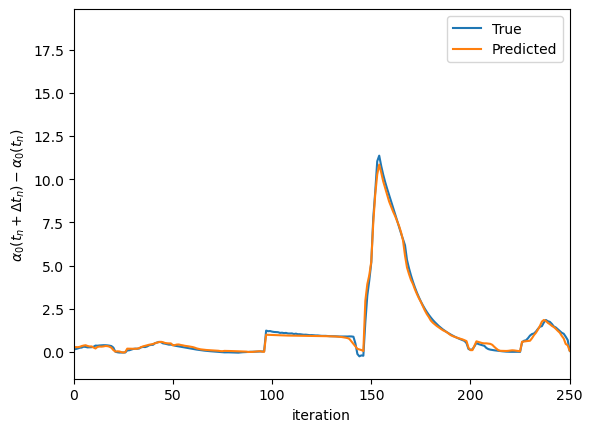

In [80]:
X_cut_tensor = torch.tensor(X_cut, dtype=torch.float32)
device = torch.device( "cpu")
print(device)
model.to(device)
index=np.linspace(1,N_cut-1,N_cut-1)
Pred=model(X_cut_tensor)
plt.plot(Y_cut[:,0],label='True')
plt.plot(Pred.detach().numpy()[:,0],label='Predicted')
plt.xlabel('iteration')
plt.ylabel(r'$\alpha_0(t_n+\Delta t_n)-\alpha_0(t_n)$')
plt.xlim(left=0,right=250)
plt.legend()

cpu


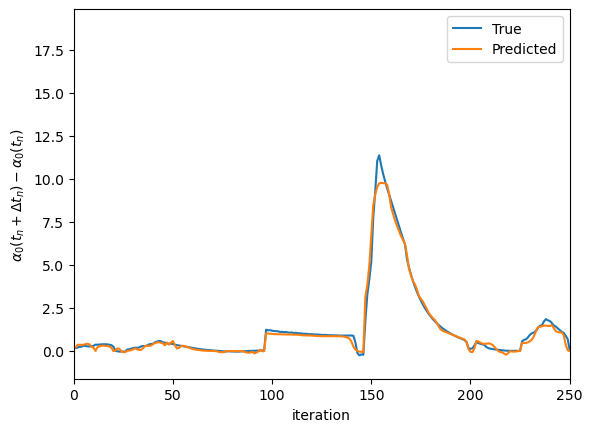

In [64]:
X_cut_tensor = torch.tensor(X_cut, dtype=torch.float32)
device = torch.device( "cpu")
print(device)
model.to(device)
index=np.linspace(1,N_cut-1,N_cut-1)
Pred=model(X_cut_tensor)
plt.plot(Y_cut[:,0],label='True')
plt.plot(Pred.detach().numpy()[:,0],label='Predicted')
plt.xlabel('iteration')
plt.ylabel(r'$\alpha_0(t_n+\Delta t_n)-\alpha_0(t_n)$')
plt.xlim(left=0,right=250)
plt.legend()

cpu


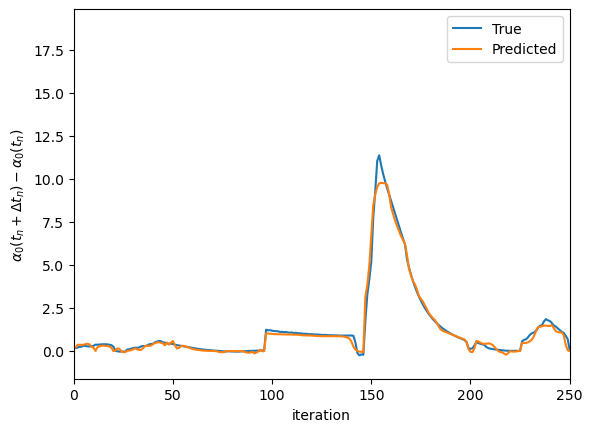

In [65]:
X_cut_tensor = torch.tensor(X_cut, dtype=torch.float32)
device = torch.device( "cpu")
print(device)
model.to(device)
index=np.linspace(1,N_cut-1,N_cut-1)
Pred=model(X_cut_tensor)
plt.plot(Y_cut[:,0],label='True')
plt.plot(Pred.detach().numpy()[:,0],label='Predicted')
plt.xlabel('iteration')
plt.ylabel(r'$\alpha_0(t_n+\Delta t_n)-\alpha_0(t_n)$')
plt.xlim(left=0,right=250)
plt.legend()

cpu


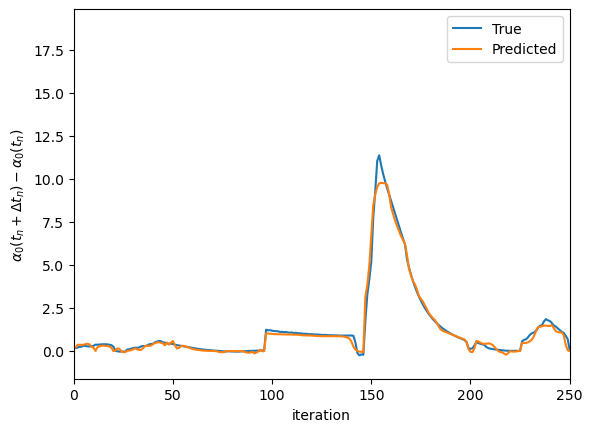

In [66]:
X_cut_tensor = torch.tensor(X_cut, dtype=torch.float32)
device = torch.device( "cpu")
print(device)
model.to(device)
index=np.linspace(1,N_cut-1,N_cut-1)
Pred=model(X_cut_tensor)
plt.plot(Y_cut[:,0],label='True')
plt.plot(Pred.detach().numpy()[:,0],label='Predicted')
plt.xlabel('iteration')
plt.ylabel(r'$\alpha_0(t_n+\Delta t_n)-\alpha_0(t_n)$')
plt.xlim(left=0,right=250)
plt.legend()

cpu


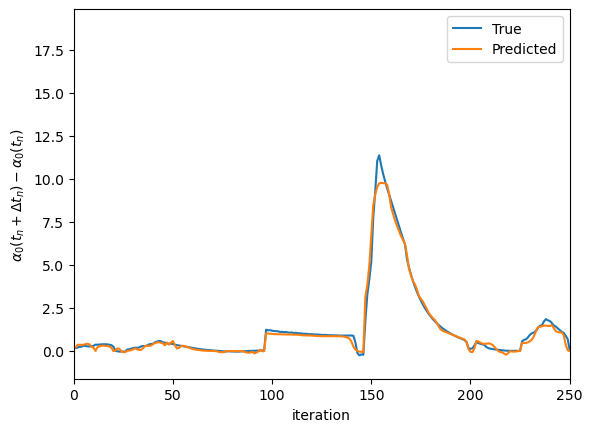

In [67]:
X_cut_tensor = torch.tensor(X_cut, dtype=torch.float32)
device = torch.device( "cpu")
print(device)
model.to(device)
index=np.linspace(1,N_cut-1,N_cut-1)
Pred=model(X_cut_tensor)
plt.plot(Y_cut[:,0],label='True')
plt.plot(Pred.detach().numpy()[:,0],label='Predicted')
plt.xlabel('iteration')
plt.ylabel(r'$\alpha_0(t_n+\Delta t_n)-\alpha_0(t_n)$')
plt.xlim(left=0,right=250)
plt.legend()


In [81]:
xk=X_cut[0,:] # Picking one initial condition, this can be any point inside the chaotic attractor
N_m=N_m_v+N_m_theta
xk=torch.tensor(xk, dtype=torch.float32)
forecast=xk.detach().numpy().reshape(N_m,1)
for index in range(50*N_cut):
    # ykp1=(model(xk))*(max_y/max_X)
    ykp1=(model(xk))
    xkp1=ykp1+xk
    numpy_vector = xkp1.detach().numpy().reshape(N_m,1)
    forecast = np.hstack([forecast, numpy_vector])
    xk=xkp1


#plt.savefig('./Figs/Forecast.png')


In [82]:
forecast.shape

(40, 100001)

(-5000.0, 5000.0)

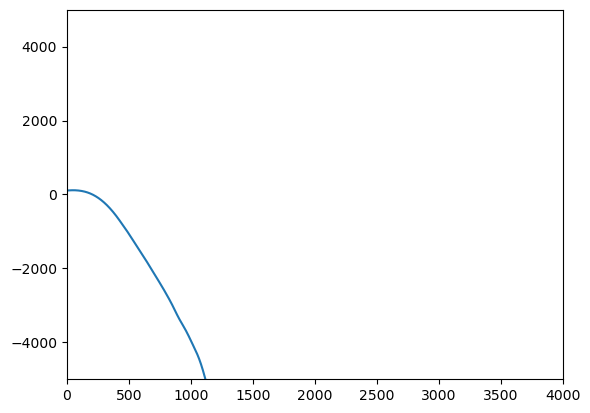

In [83]:
plt.plot(forecast[0,:])
plt.xlim(left=0,right=4000)
plt.ylim(bottom=-5000,top=5000)

(-5000.0, 5000.0)

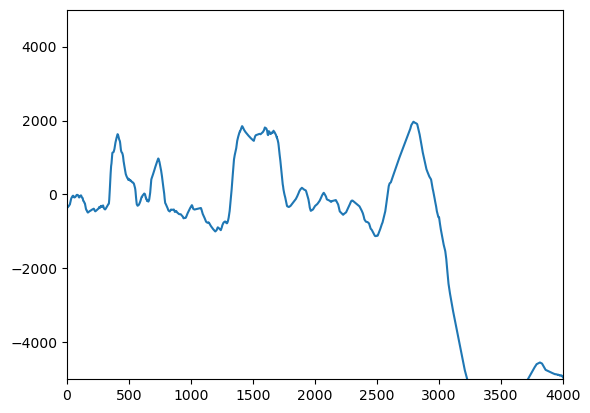

In [ ]:
plt.plot(forecast[0,:])
plt.xlim(left=0,right=4000)
plt.ylim(bottom=-5000,top=5000)

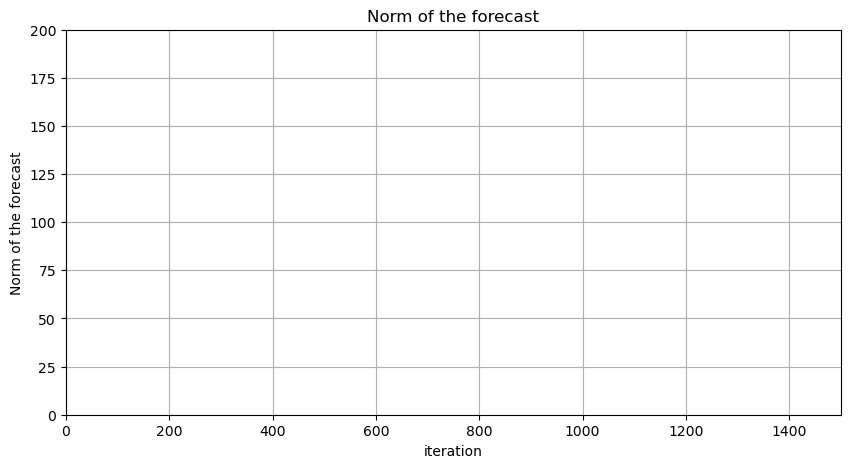

In [58]:
# # I want to plot two figures here. 
# # figure 1
# # plot the time sereis of the norm of forecast
# norm_forecast=np.linalg.norm(forecast,axis=0)
# # I want to also grid the plot very fine
# plt.figure(figsize=(10,5))
# # set xlim
# plt.xlim([0,1500])
# plt.ylim([0,200])

# # plt.plot(norm_forecast*max_X)
# plt.plot(norm_forecast)

# plt.title("Norm of the forecast")
# plt.xlabel("iteration")
# plt.ylabel("Norm of the forecast")
# plt.grid(True)
# plt.show()




In [59]:
# alpha=forecast*max_X
# alpha_v=alpha[:N_m_v,:]
# alpha_theta=alpha[N_m_v:,:]

In [60]:
# # Loading POD modes for V and Theta
# N_m_v_load=30
# N_m_theta_load=30
# data_dir="/central/groups/astuart/hkaveh/Data/LearnROM/MainSimulation_Tf600Nt=5PODonlyonV.npz"
# PODmodes=np.load(data_dir)
# U_v=PODmodes['U']
# S_v=PODmodes['S']
# VT_v=PODmodes['VT']
# q_bar_v=PODmodes['q_bar']
# Sigma_v=np.diagonal(S_v)
# Nt2=VT_v.shape[0]
# Lambda_v=Sigma_v**2/Nt2
# Lambda_v=np.atleast_2d(Lambda_v[:N_m_v_load])
# Sigma_v=(np.sqrt(Lambda_v))


# data_dir="/central/groups/astuart/hkaveh/Data/LearnROM/MainSimulation_Tf600Nt=5PODonlyontheta.npz"
# PODmodes=np.load(data_dir)
# U_theta=PODmodes['U']
# S_theta=PODmodes['S']
# VT_theta=PODmodes['VT']
# q_bar_theta=PODmodes['q_bar']
# Sigma_theta=np.diagonal(S_theta)
# Nt2=VT_theta.shape[0]
# Lambda_theta=Sigma_theta**2/Nt2
# Lambda_theta=np.atleast_2d(Lambda_theta[:N_m_theta_load])
# Sigma_theta=(np.sqrt(Lambda_theta))




In [61]:
# Sigma_v=Sigma_v[0,:N_m_v]
# Sigma_theta=Sigma_theta[0,:N_m_theta]

In [62]:
# normalized_alpha_v=alpha_v/Sigma_v[:, np.newaxis]
# normalized_alpha_theta=alpha_theta/Sigma_theta[:, np.newaxis]

In [ ]:
# apppend the normalized_alpha_v and normalized_alpha_theta
# normalized_alpha=np.append(normalized_alpha_v,normalized_alpha_theta,axis=0)

In [ ]:
# normalized_alpha.shape

(40, 10001)

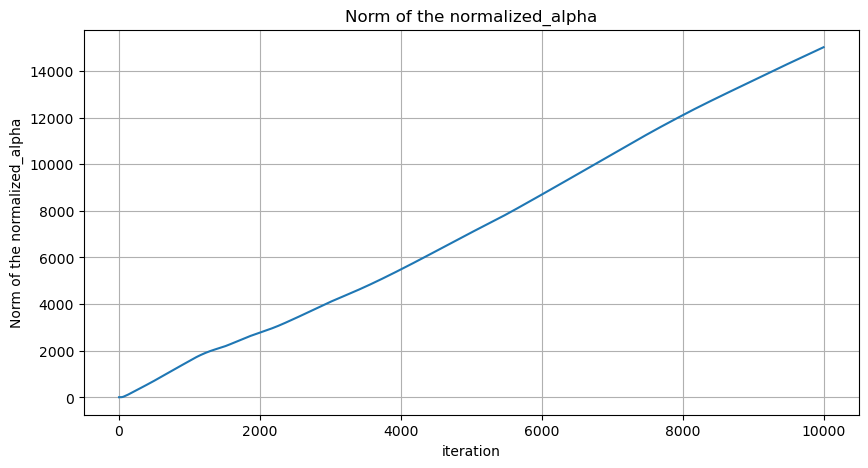

In [ ]:
# # plot the timeseries of the norm of the normalized_alpha
# norm_normalized_alpha=np.linalg.norm(normalized_alpha,axis=0)
# plt.figure(figsize=(10,5))
# plt.plot(norm_normalized_alpha)
# plt.title("Norm of the normalized_alpha")
# plt.xlabel("iteration")
# plt.xlim([0,1500])
# plt.ylim([0,100])

# plt.ylabel("Norm of the normalized_alpha")
# plt.grid(True)
# plt.show()
